# XGBoost (1) - Basic

- XGBoost는 트리 기반의 앙상블 학습에서 가장 각광받고 있는 알고리즘 중 하나
- GBM에 기반을 하고 있으면서 GMB의 실행 시간 및 과적합 규제가 없는 부분 등의 문제를 해결한 학습 모델
- 병렬 CPU환경에서 분산 처리가 가능하기 때문에 기존 모델보다 `수행 시간이 단축`된다 (수행시간에 있어서 굉장히 빠른 모델)
- `C/C++`로 구현된 독립 라이브러리이기 때문에 skleaern과의 코드 진행이 다소 다르다 (예, 데이터프레임을 안 쓴다)

## 1. 패키지 참조
```shell
pip3 install --upgrade xgboost
```

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sb
from matplotlib import pyplot as plt
from pandas import read_excel

import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

## 2. 데이터 가져오기 및 전처리

In [2]:
origin = read_excel('https://data.hossam.kr/G02/breast_cancer.xlsx')

# 독립/종속 변수 분리
x = origin.drop('target', axis = 1)
y = origin['target']

# 데이터 표준화
std_x = StandardScaler().fit_transform(x)

# 훈련/검증 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(
    std_x, y, test_size = 0.3, random_state=2021
)

# SMOTE 적용
x_sm, y_sm = SMOTE(random_state=2021).fit_resample(x_train, y_train)

x_sm.shape, y_sm.shape, x_test.shape, y_test.shape

((500, 30), (500,), (171, 30), (171,))

## 3. 훈련모델 구현

### 1) XGBoost 전용 데이터 생성
- 이미 전처리 완료된 데이터를 가져와서 적용해야 된다 - 중간에 데이터 가공이 불가능하다?
- sklearn과 다른 점은 `학습/검증을 위한 DMatrix를 생성`한다는 점이고 DMatrix는 `numpy 입력 파라미터`(데이터프레임 안 됨)를 받아 만들어지는 XGBoost만의 전용 dataset이다. 
- 주요 입력 파라미터는 `data`와 `label`이다

In [5]:
dtrain = xgb.DMatrix(data=x_sm, label=y_sm, feature_names=list(x.columns))
dtest = xgb.DMatrix(data=x_test, label=y_test, feature_names=list(x.columns))
wlist = [(dtrain, 'train'), (dtest, 'eval')] # 리스트로 묶어준다 (데이터셋1, '데이터셋1의_별명'), (데이터셋2, '데이터셋2의_별명')
wlist

[(<xgboost.core.DMatrix at 0x28d8898b0>, 'train'),
 (<xgboost.core.DMatrix at 0x28d889430>, 'eval')]

### 2) 학습 모델 적합

In [8]:
xgb_model = xgb.train(
    params = {
        'eta': 0.1,                     # 학습률
        'max_depth': 3,                 # 트리 깊이
        'objective': 'binary:logistic'  # '목적함수': 'binary:logictic' 이진분류, 'multi:softmax' 다항분류, 'multi:softprob' 각각 클래스/카테고리에 속할 확률값을 반환)
    },
    dtrain = dtrain,            # 학습데이터
    num_boost_round = 100,      # 부스팅 반복 횟수
    early_stopping_rounds = 10, # 조기 중단 설정 (큰 장점!)
    evals = wlist               # 성능 평가 데이터
)

[0]	train-logloss:0.60946	eval-logloss:0.62034
[1]	train-logloss:0.54172	eval-logloss:0.55978
[2]	train-logloss:0.48241	eval-logloss:0.50795
[3]	train-logloss:0.43177	eval-logloss:0.46037
[4]	train-logloss:0.38813	eval-logloss:0.42139
[5]	train-logloss:0.35053	eval-logloss:0.38563
[6]	train-logloss:0.31830	eval-logloss:0.35973
[7]	train-logloss:0.28949	eval-logloss:0.33181
[8]	train-logloss:0.26476	eval-logloss:0.31249
[9]	train-logloss:0.24194	eval-logloss:0.29450
[10]	train-logloss:0.22110	eval-logloss:0.27366
[11]	train-logloss:0.20403	eval-logloss:0.25987
[12]	train-logloss:0.18747	eval-logloss:0.24323
[13]	train-logloss:0.17270	eval-logloss:0.23169
[14]	train-logloss:0.15924	eval-logloss:0.21851
[15]	train-logloss:0.14745	eval-logloss:0.20865
[16]	train-logloss:0.13663	eval-logloss:0.19802
[17]	train-logloss:0.12624	eval-logloss:0.18913
[18]	train-logloss:0.11727	eval-logloss:0.18082
[19]	train-logloss:0.10887	eval-logloss:0.17397
[20]	train-logloss:0.10158	eval-logloss:0.16756
[2

### 3) 학습 결과 확인

In [13]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.994 0.983 0.977 0.003 0.996 0.04  0.001 0.996 0.011 0.999]


In [11]:
# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하여 list 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:', preds[:10])

예측값 10개만 표시: [1, 1, 1, 0, 1, 0, 0, 1, 0, 1]


### 4) 성능 평가
#### 1_ 오차 행렬 (Confusion Matrix)

In [14]:
confusion = confusion_matrix(y_test, preds)
confusion

array([[ 60,   4],
       [  2, 105]])

#### 2_ 성능지표 확인

In [15]:
accuracy = accuracy_score(y_test, preds)   # 정확도
precision = precision_score(y_test, preds) # 정밀도
recall = recall_score(y_test, preds)       # 재현율
f1 = f1_score(y_test, preds)               # 
roc_auc = roc_auc_score(y_test, preds)
print ('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

정확도: 0.9649, 정밀도: 0.9633, 재현율: 0.9813, F1: 0.9722, AUC: 0.9594


#### 3_변수 별 중요도 확인 (시각화)

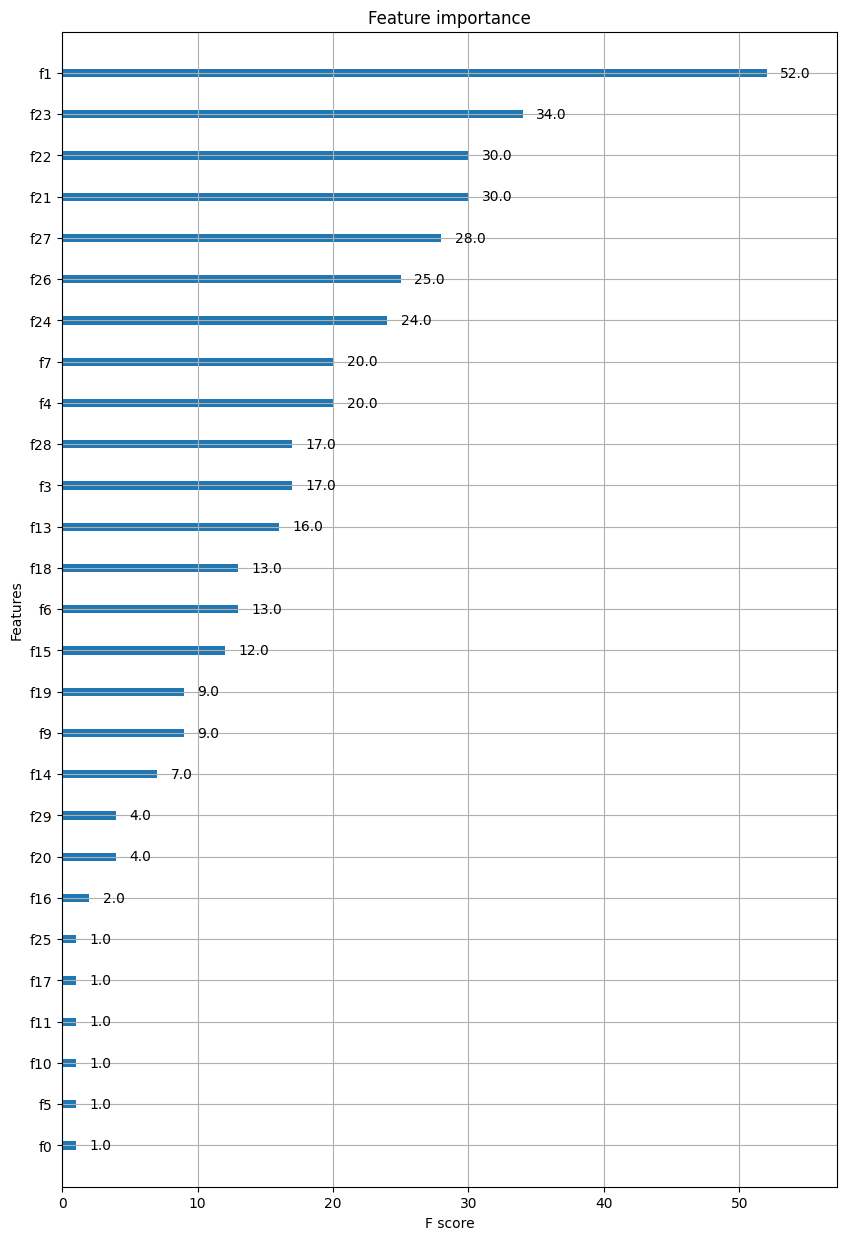

In [16]:
plt.figure(figsize=(10, 15))
plot_importance(xgb_model, ax=plt.gca())
plt.show()
plt.close()